In [1]:
import pandas as pd
import cobra
from collections import OrderedDict
from copy import deepcopy
import os,sys
model_root_path = '../'
sys.path.append(model_root_path)
from pycore.gsm_custom_functions import *
from pycore.cobrapy_custom_extras import *

In [2]:
# Metabolic model(s)
model_path = './input/iRhtoC.json'
solver = 'glpk'
# add all models as dicts 
models = [
    {'model':deepcopy(cobra.io.load_json_model(model_path)),
    'obj':'BIOMASS',
    'obj_optimal_value':0.1},
    {'model':deepcopy(cobra.io.load_json_model(model_root_path+'../scRBA/build_model/input/GSM_iSace1144_rba.json')),
    'obj':'BIOMASS_AERO_SC_hvd',
    'obj_optimal_value':0.1}
]

# Media changes

In [3]:
# manual media changes specific to the models used
models[0]['model'].medium = {'EX_glc__D_e':1.353245177,'EX_4abz_e':0.25,'EX_btn_c':0.01,'EX_ca2_e':1000,'EX_cl_e':1000,'EX_cobalt2_e':1000,'EX_cu2_e':1000,'EX_fe2_e':1000,'EX_fe3_e':1000,'EX_fol_e':0.25,'EX_h_e':1000,'EX_h2o_e':1000,'EX_inost_e':0.25,'EX_k_e':1000,'EX_mg2_e':1000,'EX_mn2_e':1000,'EX_na1_e':1000,'EX_nac_e':0.25,'EX_nh4_e':1000,'EX_ni2_e':1000,'EX_o2_e':1000,'EX_pi_e':1000,'EX_pnto__R_e':0.25,'EX_pydxn_e':0.25,'EX_ribflv_e':0.25,'EX_so4_e':1000,'EX_thm_e':0.25,'EX_zn2_e':1000}
sc_medium = models[1]['model'].medium
sc_medium['EX_glc__D_e'] = 1.353245177
models[1]['model'].medium = sc_medium
medium = models[1]['model'].medium # added since SC and RT models handle this differently
medium['EX_btn_e'] = models[0]['model'].medium['EX_btn_c']
models[1]['model'].medium = medium

In [4]:
# print media for all models
model_list = []
for model in models:
    print(model['model'].medium)
    model_list.append(model['model'])

{'EX_4abz_e': 0.25, 'EX_btn_c': 0.01, 'EX_ca2_e': 1000, 'EX_cl_e': 1000, 'EX_cobalt2_e': 1000, 'EX_cu2_e': 1000, 'EX_fe2_e': 1000, 'EX_fe3_e': 1000, 'EX_fol_e': 0.25, 'EX_glc__D_e': 1.353245177, 'EX_h2o_e': 1000, 'EX_h_e': 1000, 'EX_inost_e': 0.25, 'EX_k_e': 1000, 'EX_mg2_e': 1000, 'EX_mn2_e': 1000, 'EX_na1_e': 1000, 'EX_nac_e': 0.25, 'EX_nh4_e': 1000, 'EX_ni2_e': 1000, 'EX_o2_e': 1000, 'EX_pi_e': 1000, 'EX_pnto__R_e': 0.25, 'EX_pydxn_e': 0.25, 'EX_ribflv_e': 0.25, 'EX_so4_e': 1000, 'EX_thm_e': 0.25, 'EX_zn2_e': 1000}
{'EX_pnto__R_e': 0.25, 'EX_4abz_e': 0.25, 'EX_nh4_e': 1000.0, 'EX_btn_e': 0.01, 'EX_glc__D_e': 1.353245177, 'EX_fol_e': 0.25, 'EX_h_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_inost_e': 0.25, 'EX_nac_e': 0.25, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_k_e': 1000.0, 'EX_pydxn_e': 0.25, 'EX_ribflv_e': 0.25, 'EX_na1_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_thm_e': 0.25, 'EX_h2o_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_zn2_e': 1000.0, 'EX_mg2_e': 1000.0, 

In [5]:
# make media for all models as similar as possible
# def combine_growth_media(*model_list):
#     """MAKE SURE THAT ALL EXCHANGE REACTIONS IN MEDIA ARE IDENTICAL BEFORE USING.
#     Updates media of all models used as input, adding any of their exchange reactions that are used by the other models, with their maximum uptakes set to the highest value found in all models.
#     This ensures that the models are as similar as possible without adding new rxns, and that changing their media does not make them infeasible."""
for model in model_list:
    # set maximal_media to the medium of the 1st model in the list
    maximal_media = model_list[0].medium
    # add the highest possible value for each key; check every model in the list other than the first one
    for model in model_list[1:]:
        # for every key in the medium of the model
        for key in model.medium.keys():
            # if the key is not in maximal_media, add it
            if key not in maximal_media.keys():
                maximal_media[key] = model.medium[key]
            # if the key is in maximal_media, but the value is lower than in the model, update it
            elif maximal_media[key] < model.medium[key]:
                maximal_media[key] = model.medium[key]
    # for each model, add keys from maximal_media that are in the model's reaction list, along with their values
    for model in model_list:
        if model.medium != maximal_media:
            newmedium = model.medium
            for key in maximal_media.keys():
                if key in model.reactions:
                    if key not in model.medium.keys():
                        newmedium.update({key: maximal_media[key]})
                        print(f"Adding {key} to medium of {model} with value {maximal_media[key]}")
                    elif maximal_media[key] > model.medium[key]:
                        newmedium.update({key: maximal_media[key]})
                        print(f"Updating {key} in {model} from {model.medium[key]} to {maximal_media[key]}")
                else:
                    print(f"Reaction {key} not found in {model}")
            model.medium = newmedium

Reaction EX_btn_e not found in iRhtoC
Reaction EX_btn_c not found in yeastGEM_hvd
Reaction EX_fe3_e not found in yeastGEM_hvd
Reaction EX_btn_e not found in iRhtoC
Reaction EX_btn_c not found in yeastGEM_hvd
Reaction EX_fe3_e not found in yeastGEM_hvd


In [6]:
# more manual media changes specific to the models used
# sc_medium = models[1]['model'].medium
# sc_medium['EX_glc__D_e'] = 1.034771364
# models[1]['model'].medium = sc_medium

In [7]:
# print media for all models
for model in models:
    print(model['model'].medium)

{'EX_4abz_e': 0.25, 'EX_btn_c': 0.01, 'EX_ca2_e': 1000, 'EX_cl_e': 1000, 'EX_cobalt2_e': 1000, 'EX_cu2_e': 1000, 'EX_fe2_e': 1000, 'EX_fe3_e': 1000, 'EX_fol_e': 0.25, 'EX_glc__D_e': 1.353245177, 'EX_h2o_e': 1000, 'EX_h_e': 1000, 'EX_inost_e': 0.25, 'EX_k_e': 1000, 'EX_mg2_e': 1000, 'EX_mn2_e': 1000, 'EX_na1_e': 1000, 'EX_nac_e': 0.25, 'EX_nh4_e': 1000, 'EX_ni2_e': 1000, 'EX_o2_e': 1000, 'EX_pi_e': 1000, 'EX_pnto__R_e': 0.25, 'EX_pydxn_e': 0.25, 'EX_ribflv_e': 0.25, 'EX_so4_e': 1000, 'EX_thm_e': 0.25, 'EX_zn2_e': 1000}
{'EX_pnto__R_e': 0.25, 'EX_4abz_e': 0.25, 'EX_nh4_e': 1000.0, 'EX_btn_e': 0.01, 'EX_glc__D_e': 1.353245177, 'EX_fol_e': 0.25, 'EX_h_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_inost_e': 0.25, 'EX_nac_e': 0.25, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_k_e': 1000.0, 'EX_pydxn_e': 0.25, 'EX_ribflv_e': 0.25, 'EX_na1_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_thm_e': 0.25, 'EX_h2o_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_zn2_e': 1000.0, 'EX_mg2_e': 1000.0, 

In [8]:
# find other biomass rxns in models besides their objectives, and (optional) shut them off
for m in model_list:
    objective_rxns = []
    nonobjective_bio = []
    print(m)
    bio_rxns = find_biomass_reactions(m)
    for rxn in bio_rxns:
        if m.reactions.get_by_id(rxn.id).objective_coefficient:
            objective_rxns.append(rxn.id)
        else: # shut off rxn
            nonobjective_bio.append(rxn.id)
            m.reactions.get_by_id(rxn.id).lower_bound = 0
            m.reactions.get_by_id(rxn.id).upper_bound = 0
    print('Biomass rxns in objective function:')
    print(objective_rxns)
    print('Biomass rxns NOT in objective function:')
    print(nonobjective_bio)

iRhtoC
Biomass rxns in objective function:
['BIOMASS']
Biomass rxns NOT in objective function:
[]
yeastGEM_hvd
Biomass rxns in objective function:
['BIOMASS_AERO_SC_hvd']
Biomass rxns NOT in objective function:
[]


## adjust to data

In [9]:
atpm = 'ATPM_c'

mediaflag = 'glc-clim'
# mediaflag = 'xyl-clim'
# mediaflag = 'ac-clim'
# mediaflag = 'glc-nlim'
# mediaflag = 'xyl-nlim'
# mediaflag = 'ac-nlim'

In [10]:
# pFBAconditions = {
#     'glc': "slope = 1; intercept = 0; medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-glc-RekenaEtAl2023.xlsx'); model.reactions.get_by_id('BIOMASS').bounds = (0.19069533756447, 0.19069533756447); model.reactions.get_by_id('EX_glc__D_e').bounds = (-2.09564029108156, -2.09564029108156); model.reactions.get_by_id('EX_xylt_e').bounds = (0, 0); model.reactions.get_by_id('EX_abt__D_e').bounds = (0, 0)",
#     'xyl': "slope = 1; intercept = 0; medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-xyl-RekenaEtAl2023.xlsx'); model.reactions.get_by_id('BIOMASS').bounds = (0.053826805331985, 0.053826805331985); model.reactions.get_by_id('EX_xyl__D_e').bounds = (-1.85920688472307, -1.85920688472307); model.reactions.get_by_id('EX_xylt_e').bounds = (0.223025025018752, 0.223025025018752); model.reactions.get_by_id('EX_abt__D_e').bounds = (0.367429717476936, 0.367429717476936)",
#     'ac': "slope = 1; intercept = 0; medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-ac-RekenaEtAl2023.xlsx'); model.reactions.get_by_id('BIOMASS').bounds = (0.0729833144786101, 0.0729833144786101); model.reactions.get_by_id('EX_ac_e').bounds = (-6.62680929723702, -6.62680929723702); model.reactions.get_by_id('EX_xylt_e').bounds = (0, 0); model.reactions.get_by_id('EX_abt__D_e').bounds = (0, 0)"
# }
pFBAconditions = {
    'glc-clim': "medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-glc-RekenaEtAl2023.xlsx'); slope = 104.6479; intercept = 0; model.reactions.get_by_id('BIOMASS').bounds = (0.19069533756447, 0.19069533756447); model.reactions.get_by_id('EX_glc__D_e').bounds = (-2.09564029108156, -2.09564029108156); model.reactions.get_by_id('EX_xylt_e').bounds = (0, 0); model.reactions.get_by_id('EX_abt__D_e').bounds = (0, 0); model.reactions.get_by_id('EX_cit_e').bounds = (0, 0); model.reactions.get_by_id('EX_glyc_e').bounds = (0.049224180890395, 0.049224180890395)",
    'xyl-clim': "medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-xyl-RekenaEtAl2023.xlsx'); slope = 370.8052; intercept = 4.9039; model.reactions.get_by_id('BIOMASS').bounds = (0.053826805331985, 0.053826805331985); model.reactions.get_by_id('EX_xyl__D_e').bounds = (-1.85920688472307, -1.85920688472307); model.reactions.get_by_id('EX_xylt_e').bounds = (0.223025025018752, 0.223025025018752); model.reactions.get_by_id('EX_abt__D_e').bounds = (0.367429717476936, 0.367429717476936); model.reactions.get_by_id('EX_cit_e').bounds = (0, 0); model.reactions.get_by_id('EX_glyc_e').bounds = (0, 0)",
    'ac-clim': "medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-ac-RekenaEtAl2023.xlsx'); slope = 598.9104; intercept = 0; model.reactions.get_by_id('BIOMASS').bounds = (0.0729833144786101, 0.0729833144786101); model.reactions.get_by_id('EX_ac_e').bounds = (-6.62680929723702, -6.62680929723702); model.reactions.get_by_id('EX_xylt_e').bounds = (0, 0); model.reactions.get_by_id('EX_abt__D_e').bounds = (0, 0); model.reactions.get_by_id('EX_cit_e').bounds = (0.121622425730085, 0.121622425730085); model.reactions.get_by_id('EX_glyc_e').bounds = (0, 0)",
    'glc-nlim': "medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-glc-RekenaEtAl2023.xlsx'); slope = 89.419; intercept = 0; model.reactions.get_by_id('BIOMASS').bounds = (0.19069533756447, 0.19069533756447); model.reactions.get_by_id('EX_glc__D_e').bounds = (-2.09564029108156, -2.09564029108156); model.reactions.get_by_id('EX_xylt_e').bounds = (0, 0); model.reactions.get_by_id('EX_abt__D_e').bounds = (0, 0); model.reactions.get_by_id('EX_cit_e').bounds = (0, 0); model.reactions.get_by_id('EX_glyc_e').bounds = (0.049224180890395, 0.049224180890395)",
    'xyl-nlim': "medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-xyl-RekenaEtAl2023.xlsx'); slope = 370.8052; intercept = 4.9039; model.reactions.get_by_id('BIOMASS').bounds = (0.053826805331985, 0.053826805331985); model.reactions.get_by_id('EX_xyl__D_e').bounds = (-1.85920688472307, -1.85920688472307); model.reactions.get_by_id('EX_xylt_e').bounds = (0.223025025018752, 0.223025025018752); model.reactions.get_by_id('EX_abt__D_e').bounds = (0.367429717476936, 0.367429717476936); model.reactions.get_by_id('EX_cit_e').bounds = (0, 0); model.reactions.get_by_id('EX_glyc_e').bounds = (0, 0)",
    'ac-nlim': "medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-ac-RekenaEtAl2023.xlsx'); slope = 598.9104; intercept = 0; model.reactions.get_by_id('BIOMASS').bounds = (0.0729833144786101, 0.0729833144786101); model.reactions.get_by_id('EX_ac_e').bounds = (-6.62680929723702, -6.62680929723702); model.reactions.get_by_id('EX_xylt_e').bounds = (0, 0); model.reactions.get_by_id('EX_abt__D_e').bounds = (0, 0); model.reactions.get_by_id('EX_cit_e').bounds = (0.121622425730085, 0.121622425730085); model.reactions.get_by_id('EX_glyc_e').bounds = (0, 0)"
}
exec(pFBAconditions[mediaflag], globals())

AttributeError: 'dict' object has no attribute 'reactions'

In [ ]:
# optional: update metabolic model
# Load the Excel file containing reaction names and upper bounds
#medium_data = pd.read_excel("./input/precursors/build_model/input/precursors/ypd_glc_cobalt2_urea_not_nh4.xlsx")
# medium_data = pd.read_excel('./input/precursors/RekenaEtAl2023/media-experimentalv2-glc-RekenaEtAl2023.xlsx')

# Create a dictionary to store the upper bounds for each reaction

def newMedium(cell):
    reaction_upper_bounds = {}
    print(medium_data)
    # Iterate through the rows of the CSV file and update the upper bounds
    for _, row in medium_data.iterrows():
        reaction_name = row['exchange']
        upper_bound = row['uptake']
        
        # Check if the reaction exists in the model
        if reaction_name in cell.reactions:
            reaction = cell.reactions.get_by_id(reaction_name)
            
            # Update the upper bound of the reaction
            reaction.upper_bound = upper_bound
            
            # Store the updated upper bound in the dictionary
            reaction_upper_bounds[reaction_name] = upper_bound
    # Access the model's medium using the reaction_upper_bounds dictionary
    medium = {}
    for reaction_name, upper_bound in reaction_upper_bounds.items():
        medium[reaction_name] = upper_bound
    return medium

: 

In [ ]:
# OPTIONAL: Print the updated medium
model.medium = newMedium(model)

        exchange   uptake                                            comment
0       EX_btn_c     0.01                                                NaN
1         EX_k_e  1000.00                                                NaN
2        EX_pi_e  1000.00                                                NaN
3       EX_mg2_e  1000.00                                                NaN
4       EX_so4_e  1000.00                                                NaN
5       EX_h2o_e  1000.00                                                NaN
6       EX_zn2_e  1000.00                                                NaN
7   EX_cobalt2_e  1000.00                                                NaN
8        EX_cl_e  1000.00                                                NaN
9       EX_mn2_e  1000.00                                                NaN
10      EX_cu2_e  1000.00                                                NaN
11      EX_ca2_e  1000.00                                                NaN

: 

In [ ]:
exec(pFBAconditions[mediaflag], globals())

: 

In [ ]:
model.medium

{'EX_pnto__R_e': 0.25,
 'EX_4abz_e': 0.25,
 'EX_glc__D_e': 2.09564029108156,
 'EX_fe2_e': 1000.0,
 'EX_inost_e': 0.25,
 'EX_nac_e': 0.25,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_pydxn_e': 0.25,
 'EX_na1_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_thm_e': 0.25,
 'EX_urea_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 0.25,
 'EX_zn2_e': 1000.0,
 'EX_btn_c': 0.01}

: 

In [ ]:
# Initialize a dictionary to store the output of each condition's commands
output_dict = {}
# Get the current script's name (including path) - only tested it in VScode, so may need to change variable name
script_name = os.getcwd() + "/" + os.path.basename(globals()['__vsc_ipynb_file__'])
# Modify the script name to create the output file name
file_name_template = script_name.replace(".ipynb", "_output.txt")
print(file_name_template)
# Initialize a counter
counter = 0
output_file_name = script_name.replace(".ipynb", "_output_"+mediaflag+".txt")
print(output_file_name)

c:\Users\Eric Mooney\Documents\rtRBA-main\build_model/pfba-minimal_output.txt
c:\Users\Eric Mooney\Documents\rtRBA-main\build_model/pfba-minimal_output_glc-clim.txt


: 

# run FVA

In [ ]:
# FVA on all models
for m in model_list:
    fva = cobra.flux_analysis.flux_variability_analysis(m)
    models[model_list.index(m)]['fva'] = fva

In [ ]:
# find rxns with highest absolute fluxes in FVA for RT
fva = models[0]['fva']
fva['absmax'] = fva[['minimum', 'maximum']].abs().max(axis=1)
fva = fva.sort_values(by='absmax', ascending=False)
fva = fva.drop(columns='absmax')
fva.to_csv('fva_RT.csv')
# fva

In [ ]:
# find rxns that are unblocked in all models
# unblocked_rxns_in_all_models = []
# for rxn in models[0]['fva'].index:
#     unblocked = True
#     for m in models[1:]:
#         if rxn not in m['fva'].index or (m['fva'].loc[rxn]['minimum'] == 0 and m['fva'].loc[rxn]['maximum'] == 0):
#             unblocked = False
#             break
#     if unblocked:
#         unblocked_rxns_in_all_models.append(rxn)
# print(f"Found {len(unblocked_rxns_in_all_models)} reactions unblocked in all models.")
# print(unblocked_rxns_in_all_models)
# find blocked and unblocked rxns in each model
all_unblocked_rxns = set()
for m in models:
    m['blocked-rxns'] = []
    m['unblocked-rxns'] = []
    for rxn in m['fva'].index:
        if m['fva'].loc[rxn]['minimum'] == 0 and m['fva'].loc[rxn]['maximum'] == 0:
            m['blocked-rxns'].append(rxn)
        else:
            m['unblocked-rxns'].append(rxn)
            all_unblocked_rxns.add(rxn)
    print(f"Model {models.index(m)} has {len(m['unblocked-rxns'])} unblocked reactions.")
    print(m['unblocked-rxns'])
# find rxns that are unblocked in all models
unblocked_rxns_in_all_models = []
all_unblocked_rxns = list(all_unblocked_rxns)
print(all_unblocked_rxns)
for rxn in all_unblocked_rxns:
    unblocked = True
    for m in models:
        if rxn not in m['unblocked-rxns']:
            unblocked = False
            break
    if unblocked:
        unblocked_rxns_in_all_models.append(rxn)
print(f"Found {len(unblocked_rxns_in_all_models)} reactions unblocked in every model.")

Model 0 has 1335 unblocked reactions.
['ADPh_c', 'ADPh_m', 'RLFC2O_c', 'RLFC2O_m', 'BTDDH_c', 'LLFC2O_c', '13GS_c', '16GS_c', 'PRMICI_c', 'P5CD2_m', 'DHPPDA2_c', 'DRAPPRy_c', 'ACHBS_m', 'HPPK2_m', 'AATA_c', 'DPR_c', 'IPPMIb_c', 'UNK3_c', 'HCITR_m', 'OMCDC_c', 'BPNT_c', 'PDE1_c', 'DB4PS_c', 'DHQTi_c', 'DHQS_c', '3DSPHR_r', 'DDPA_c', 'HKYNH_c', 'HACD140i_x', '3HAO_c', 'IPPMIa_c', 'IPMD_c', '3MOBDC_c', 'MTMOHT_m', '3MOPDC_c', 'PSCIT_c', 'ADCS_c', 'ADCL_c', 'ABTA_c', 'MTAP_c', 'NTD4pp_c', 'NTD2pp_c', 'PRFGS_c', 'MTHFR3_c', 'ALAS_m', 'MDRPD_c', 'MTRI_c', 'ACALDCD_c', 'KARA1i_m', 'ACLS_m', 'ACACT180i_x', 'ACACT260i_x', 'ACACT160i_x', 'ACACT40ir_c', 'ACACT140i_x', 'ACACT100i_x', 'ACACT120i_x', 'ACGK_m', 'ACOTAi_m', 'ACOAO260_x', 'ACOAO160_x', 'ACOAO180_x', 'ACOAO140_x', 'ADD_c', 'ADPT_c', 'ADA_c', 'ADNK1_c', 'AMPDA_c', 'AHCi_c', 'ADMDC_c', 'ADNCYC_c', 'ADK1_c', 'ADK1_m', 'ADK3_m', 'ADSL2i_c', 'ADSL1r_c', 'ADSS_c', 'ADSK_c', 'AGTi_c', 'ALATRS_c', 'ALCD22xi_c', 'ALCD22xi_m', 'ALCD22yi_c', 'ALCD

# run pFBA

In [ ]:
# pFBA
# Maximize ATPM at the given growth rate to check if it's possible. Helps account for possible rounding errors in GAM/NGAM.
# model.reactions.get_by_id(atpm).lower_bound = 0
# model.objective = atpm
# print(model.objective)
# model.objective_direction = "max"
# fba_solution = model.optimize()
# max_atpm = fba_solution.objective_value
# print("Max flux through",atpm+":",max_atpm)

# old_atpm = float(intercept) + (float(slope) * model.reactions.get_by_id(obj).lower_bound)
# print("GAM+NGAM =",old_atpm)
# if old_atpm <= max_atpm:
#     if intercept < 0:
#         model.reactions.get_by_id(atpm).lower_bound = 0
#         # model.reactions.get_by_id('ATPM_c').lower_bound = (slope * model.reactions.get_by_id(obj).lower_bound) - intercept
#     else: 
#         model.reactions.get_by_id(atpm).lower_bound = old_atpm
# else:
#     model.reactions.get_by_id(atpm).lower_bound = max_atpm

for m in model_list:
    # force objective to value from dict
    m.reactions.get_by_id(models[model_list.index(m)]['obj']).upper_bound = models[model_list.index(m)]['obj_optimal_value']
    fba_solution = m.optimize()
    pfba = cobra.flux_analysis.pfba(m)
    # solution = pfba.fluxes[obj]
    # print("FBA Objective: ",model.objective)
    # print("Result: ",solution)
    print("Status: " + pfba.status + ". Objective value: " + str(pfba.objective_value))
    print("Nonzero fluxes:")
    # add pFBA results to "models" dict
    for model in models:
        models[model_list.index(m)]['pfba'] = pfba
    for reaction, flux in pfba.fluxes.items():
        if flux != 0.0:
            print(f"Reaction ID: {reaction}, Flux: {flux}")
    # make Escher model
    make_escher_csv(pfba.fluxes, f'./{m.id}_escher.csv')
    # check if an alternative pFBA solution is possible by constraining the sum of the absolute values of fluxes to be equal to its value in the original pFBA solution
    with m as m_pfba:
        sum_abs_fluxes = pfba.objective_value
        # force the sum of the absolute values of fluxes to be equal to its value in the original pFBA solution
        coefficients = dict()
        for rxn in m_pfba.reactions:
            coefficients[rxn.forward_variable] = 1.
            coefficients[rxn.reverse_variable] = 1.
        constraint = m_pfba.problem.Constraint(0, lb=0, ub=sum_abs_fluxes)
        m_pfba.add_cons_vars(constraint)
        m_pfba.solver.update()
        constraint.set_linear_coefficients(coefficients=coefficients)
        # loop over all unblocked reactions (according to FVA) until an alternative FBA solution is found
        unblocked_rxns = models[model_list.index(m_pfba)]['unblocked-rxns']
        for rxn in unblocked_rxns:
            # add new constraint: rxn's flux can't equal its pFBA value
            # try increasing the flux
            diff = m_pfba.reactions.get_by_id(rxn).upper_bound - pfba.fluxes[rxn]
            # objective: maximize flux of rxn - pfba.fluxes[rxn]
            if diff > m_pfba.tolerance:
                diff_flux = m_pfba.problem.Constraint(m_pfba.reactions.get_by_id(rxn).flux_expression - pfba.fluxes[rxn], lb=m_pfba.tolerance, ub=diff)
                m_pfba.add_cons_vars(diff_flux)
                # run FBA
                m_pfba.objective = m_pfba.problem.Objective(m_pfba.reactions.get_by_id(rxn).flux_expression - pfba.fluxes[rxn], direction='max')
                pfba_alt = m_pfba.optimize()
                # if it's feasible, break the loop
                if pfba_alt.status == 'optimal':
                    # find sum of all fluxes
                    sum_fluxes = 0
                    for r in m_pfba.reactions:
                        sum_fluxes += abs(pfba_alt.fluxes[r.id])
                    print(f"Alternative pFBA solution found (pFBA objective value:{sum_fluxes}), where flux of {rxn} is {pfba_alt.fluxes[rxn]} instead of {pfba.fluxes[rxn]}.")
                    break
                else:
                    # remove diff_flux constraint if infeasible
                    m_pfba.remove_cons_vars(diff_flux)
            # try decreasing the flux
            diff = pfba.fluxes[rxn] - m_pfba.reactions.get_by_id(rxn).lower_bound
            # maximize the difference
            if diff < m_pfba.tolerance:
                # remove diff_flux constraint if already added
                if m_pfba.problem.Constraint in [type(c) for c in m_pfba.constraints]:
                    m_pfba.remove_cons_vars(m_pfba.constraints[-1])
                diff_flux = m_pfba.problem.Constraint(pfba.fluxes[rxn] - m_pfba.reactions.get_by_id(rxn).flux_expression, lb=m_pfba.tolerance, ub=diff)
                m_pfba.add_cons_vars(diff_flux)
                # run FBA
                m_pfba.objective = m_pfba.problem.Objective(pfba.fluxes[rxn] - m_pfba.reactions.get_by_id(rxn).flux_expression, direction='max')
                pfba_alt = m_pfba.optimize()
                # if it's feasible, break the loop
                if pfba_alt.status == 'optimal':
                    # find sum of all fluxes
                    sum_fluxes = 0
                    for r in m_pfba.reactions:
                        sum_fluxes += abs(pfba_alt.fluxes[r.id])
                    print(f"Alternative pFBA solution found (pFBA objective value:{sum_fluxes}), where flux of {rxn} is {pfba_alt.fluxes[rxn]} instead of {pfba.fluxes[rxn]}.")
                    break
                else:
                    # remove diff_flux constraint if infeasible
                    m_pfba.remove_cons_vars(diff_flux)


Status: optimal. Objective value: 202.405816634219
Nonzero fluxes:
Reaction ID: 13GS_c, Flux: 0.11125090503604501
Reaction ID: 16GS_c, Flux: 0.0292766182930232
Reaction ID: PRMICI_c, Flux: 0.00648247074259887
Reaction ID: DHPPDA2_c, Flux: 2.222522208281e-05
Reaction ID: DRAPPRy_c, Flux: 2.222522208281e-05
Reaction ID: ACHBS_m, Flux: 0.019783336441005103
Reaction ID: AATA_c, Flux: 0.022067264266924302
Reaction ID: IPPMIb_c, Flux: -0.0269039272557864
Reaction ID: UNK3_c, Flux: 1.1112611041405e-05
Reaction ID: HCITR_m, Flux: 0.022067264266924302
Reaction ID: OMCDC_c, Flux: 0.0269039272557864
Reaction ID: BPNT_c, Flux: 0.004321528411110553
Reaction ID: DB4PS_c, Flux: 4.445044416562e-05
Reaction ID: DHQTi_c, Flux: 0.021395585756649467
Reaction ID: DHQS_c, Flux: 0.021395585756649467
Reaction ID: 3DSPHR_r, Flux: 0.00089801009825594
Reaction ID: DDPA_c, Flux: 0.021395585756649467
Reaction ID: IPPMIa_c, Flux: -0.0269039272557864
Reaction ID: IPMD_c, Flux: 0.0269039272557864
Reaction ID: PSCIT_c

# Plot results

In [ ]:
# find rxns unique to each model
for m in models:
    m['unique-rxns'] = []
    for rxn in m['unblocked-rxns']:
        if rxn not in unblocked_rxns_in_all_models:
            m['unique-rxns'].append(rxn)
    # print top 3 with highest absolute fluxes in pFBA
    print(f"Model {models.index(m)} has {len(m['unique-rxns'])} unique reactions.")
    # print(m['unique-rxns'])
    pfba = m['pfba']
    pfba = pfba.to_frame()
    pfba['abs'] = pfba['fluxes'].abs()
    # add column noting if reaction is unique to this model
    pfba['unique'] = pfba.index.isin(m['unique-rxns'])
    # make csv
    pfba.to_csv(f'pfba_{m["model"].id}.csv')
    # pfba = pfba.sort_values(by='abs', ascending=False)
    # print('Top 3 reactions with highest absolute fluxes in pFBA:')
    # print(pfba.head(3))

Model 0 has 317 unique reactions.
Model 1 has 397 unique reactions.


y = 1.69x + 0.0
R^2 = 0.8879148759475032
385 rxns used in both models out of 1018 unblocked rxns in all (from FVA)
iRhto1111C: 468 out of 1335 unblocked reactions used
yeastGEM_hvd: 443 out of 1415 unblocked reactions used
Top 5 furthest reactions from 45-degree line (in blue), 
sorted from closest to furthest (SC flux, RT flux):
As a list: ['H2Ot_c_m', 'PItps_m', 'ADPATPt_c_m', 'MDH_c', 'AKGMALta_m']
More detail:
Reaction: AKGMALta_m, coordinates: (0.0, 4.365429651403007)
Reaction: MDH_c, coordinates: (-0.1568465000000063, -4.9305116089067145)
Reaction: ADPATPt_c_m, coordinates: (11.65262096654845, 20.65689294033561)
Reaction: PItps_m, coordinates: (9.816692392868811, 20.65689294033561)
Reaction: H2Ot_c_m, coordinates: (-14.145691415740432, -25.85982517069401)


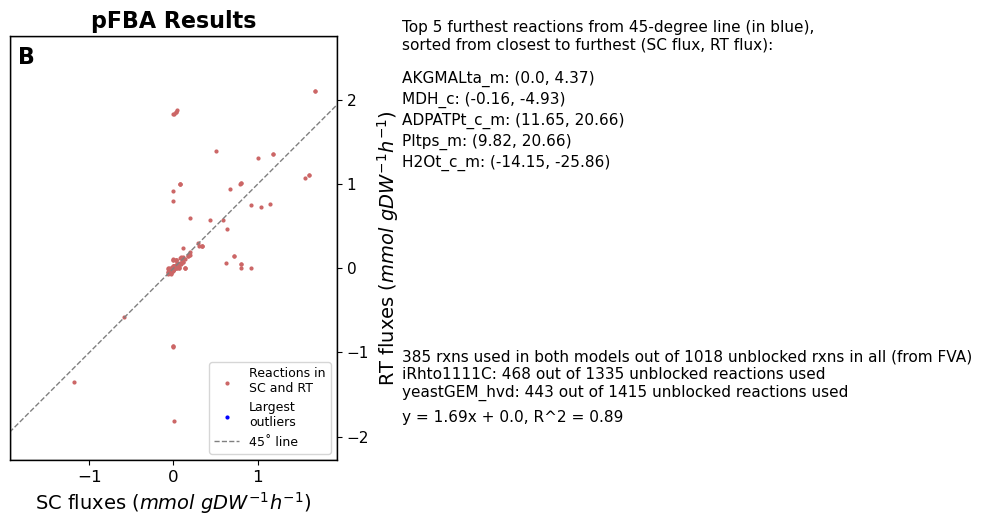

In [ ]:
# finding fluxes of rxns in both models, the trendline for them, and determining which reactions are furthest from it
# finding fluxes of # find rxns in both models
import matplotlib.pyplot as plt
import numpy as np
sigfigs = 2
outside_graph_margin = 1.2
rxns = []
for model in models:
    rxns.append(list(model['pfba'].fluxes.keys()))
common_rxns = list(set(rxns[0]).intersection(rxns[1]))
# get fluxes for common rxns
fluxes = []
for model in models:
    fluxes.append([model['pfba'].fluxes[rxn] for rxn in common_rxns])

plt.title('pFBA Results',fontsize=16,fontweight='bold')
# font size for title
plt.rcParams.update({'font.size': 11})

x = np.array(fluxes[1])
y = np.array(fluxes[0])
trendline = np.polyfit(x, y, 1)
m = trendline[0]
b = trendline[1]
# show trendline equation
trendline_equation = f"y = {round(m,ndigits=sigfigs)}x {'+' if b > 0 else '-'} {abs(round(b,ndigits=sigfigs))}"
print(trendline_equation)

# Calculate the distances of each point from the trendline
# distances = np.abs(y - (m * x + b))
# calculate distances from trendline by using lines normal to the trendline
## ATTEMPT 1
# distances = np.abs(m*x - y + b) / np.sqrt(m**2 + 1)
# # ATTEMPT 2: orthogonal distance regression
# m_normal = -1/m
# # calculate where the normal line for each point intersects the trendline
# normal_line_intercepts = y - m_normal*x
# # calculate the x and y coordinates of the intersection points.
# ## since the normal line intersects the trendline, y=mx+b, then at the intersection point, y = m_normal*x + b_normal = m*x + b.
# ## therefore, x = (b_normal - b) / (m - m_normal).
# x_intercepts = (normal_line_intercepts - b) / (m - m_normal)
# y_intercepts = m * x_intercepts + b
# # calculate the distances between the points and the intersection points
# distances = np.sqrt((x - x_intercepts)**2 + (y - y_intercepts)**2)
# # calculate the minimum distances (using orthogonal residuals) between the points and the 45-degree line
# ATTEMPT 3: calculate distances from 45-degree line. DO this to find the most overestimated and underestimated rxns.
distances = np.abs(x - y) / np.sqrt(2)
# proof that the distances are correct:
## since the normal line intersects the 45-degree line at 45 degrees, 
## the distance between the point and the 45-degree line is the same as the distance between the point and the intersection of the normal line with the 45-degree line (it's an isosceles right triangle).

# draw the normal lines between each point and the normal line's intersection with the trendline
# for i in range(len(x)):
#     plt.plot([x[i], x_intercepts[i]], [y[i], y_intercepts[i]], color='green', ls='--')

# calculate the correlation coefficient
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(f"R^2 = {r_squared}")

# Sort the distances in descending order and get the indices of the top 5 furthest points
top_indices = np.argsort(distances)[-5:]

# Define a desaturated red color
desaturated_red = (0.8, 0.4, 0.4)  # RGB values between 0 and 1

# Plot the points
dotsize=4
plt.scatter(x, y, color=desaturated_red, s=dotsize)

# Plot the top 5 furthest points in blue
plt.scatter(x[top_indices], y[top_indices], color='blue', s=dotsize)
# fig, ax = plt.subplots()

# Plot the trendline in orange
# plt.plot(x, m * x + b, color='orange',linewidth=1)
# remove gridlines from plot
plt.grid(False)
# add 45-degree line that covers the whole plot
plt.plot([min(x), max(x)], [min(x), max(x)], color='gray',ls='--',linewidth=1)
# remove top and right spines
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
# make ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels larger
plt.xlabel('SC fluxes ($mmol\ gDW^{-1}h^{-1}$)', fontsize=14)
plt.ylabel('RT fluxes ($mmol\ gDW^{-1}h^{-1}$)', fontsize=14)
# add legend; plot it inside the plot area and avoid overlapping with the plot
# plt.legend(['Reactions in\nSC and RT', 'Largest\noutliers', 'Trendline', '45˚ line'], loc='lower right',fontsize=9)
plt.legend(['Reactions in\nSC and RT', 'Largest\noutliers', '45˚ line'], loc='lower right',fontsize=9)
# plt.legend(['Trendline', '45-degree line', 'Top 5 furthest points', 'All points'], loc='best', bbox_to_anchor=(0.01, 0.99), fontsize=9)
# add text with R^2 value
# plt.rcParams['text.usetex'] = False
plt.text(outside_graph_margin, 0.1, f'{trendline_equation}, R^2 = {round(r_squared,ndigits=sigfigs)}', ha='left', va='center', transform=plt.gca().transAxes)
# plt.text(outside_graph_margin, 0.01, trendline_equation, ha='left', va='center', transform=plt.gca().transAxes)
# add text with number of points
# sample_size_string = f"Number of points: {len(x)}"
nonblocked_points = len([i for i in range(len(x)) if x[i] != 0 and y[i] != 0])
# if nonblocked_points < len(x):
#     sample_size_string += f"; {nonblocked_points} not at (0,0)"
sample_size_string = f"{nonblocked_points} rxns used in both models out of {len([i for i in common_rxns if i in unblocked_rxns_in_all_models])} unblocked rxns in all (from FVA)"
# list unblocked rxns
for model in models:
    # find rxns in both models that this model uses in pFBA
    sample_size_string += f"\n{models[models.index(model)]['model'].id}: {len([models[models.index(model)]['pfba'].fluxes[rxn] for rxn in common_rxns if models[models.index(model)]['pfba'].fluxes[rxn] != 0])} out of {len(models[models.index(model)]['unblocked-rxns'])} unblocked reactions used"
plt.text(outside_graph_margin, 0.2, sample_size_string, ha='left', va='center', transform=plt.gca().transAxes)

# print number of points
print(sample_size_string)
# print names and fluxes (in both models) of the furthest rxns from trendline (in top_indices)
outlier_str=f"Top {len(top_indices)} furthest reactions from 45-degree line (in blue), \nsorted from closest to furthest (SC flux, RT flux):"
print(outlier_str)
plt.text(outside_graph_margin, 1, outlier_str, ha='left', va='center', transform=plt.gca().transAxes)
print("As a list: " + str([common_rxns[i] for i in reversed(top_indices)]))
print("More detail:")
for i in top_indices:
    print(f"Reaction: {common_rxns[i]}, coordinates: ({x[i]}, {y[i]})")
    # on plot, show name of rxn
    # plt.text(x[i], y[i], common_rxns[i], fontsize=9)
    # next to the plot, in the image, show names of rxns furthest from trendline
    plt.text(outside_graph_margin, 0.95 - 0.05*(top_indices.tolist().index(i)+1), f"{common_rxns[i]}: ({round(x[i],ndigits=sigfigs)}, {round(y[i],ndigits=sigfigs)})", ha='left', va='center', transform=plt.gca().transAxes)
    # add label next to point; try to not make them overlap with each other or with the plot, and force them to be inside the plot
    # if the point is in the top right quadrant, place the label to the left of the point
    va=1 if y[i] >= 0 else -1 # 1=top, -1=bottom
    ha=1 if x[i] >= 0 else -1 # 1=right, -1=left
    # if there's a point to the right of the label, place the label above the point
    if any([x[j] > x[i] for j in range(len(x))]):
        va=-va
    va_final='top' if va == 1 else 'bottom'
    ha_final='right' if ha == 1 else 'left'
    plt.annotate(common_rxns[i], (x[i], y[i]),fontsize=7,ha=ha_final,va=va_final,xytext=(-ha*3.7,-va*3.7),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='black',lw=1,connectionstyle='arc3,rad=0'))
# display the plot
# Show the plot
# force aspect ratio to be 1:1
# plt.axis('equal')
plt.axis('scaled')
# make plot a bit wider
plt.gcf().set_size_inches(5.5,5.5)
# add letter A to top left corner
from matplotlib.artist import Artist
# fig, ax = plt.subplots()
frame = plt.text(0.05, 0.95, 'A', ha='center', va='center', transform=plt.gca().transAxes, fontsize=16,fontweight='bold')
# To show the artist
Artist.set_visible(frame, True)
# save as an SVG file
plt.savefig('fluxes_scatterplot.svg', format='svg')
# save another version zoomed in on the part w/o the outliers
# find the highest and lowest x and y values among non-outliers
max_x = max([x[i] for i in range(len(x)) if i not in top_indices])
min_x = min([x[i] for i in range(len(x)) if i not in top_indices])
max_y = max([y[i] for i in range(len(y)) if i not in top_indices])
min_y = min([y[i] for i in range(len(y)) if i not in top_indices])

# draw version of the plot with a box around the zoomed-in area
plt.gca().add_patch(plt.Rectangle((min_x*0.4, min_y*0.4), (max_x-min_x)*0.4, (max_y-min_y)*0.4, fill=None, edgecolor='black', linewidth=1))
plt.savefig('fluxes_scatterplot_with_zoomed_box.svg', format='svg')
# draw the zoomed in version
plt.xlim(min_x*0.4, max_x*.4)
plt.ylim(min_y*0.4, max_y*.4)
# remove spines
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)
# move axis and labels to the right side of the plot
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
# To hide the previous letter

Artist.set_visible(frame, False)
# add letter B to top left corner
plt.text(0.05, 0.95, 'B', ha='center', va='center', transform=plt.gca().transAxes, fontsize=16,fontweight='bold')
plt.savefig('fluxes_scatterplot_zoomed.svg', format='svg')
plt.show()

In [ ]:
# display all rxns with nonzero fluxes in each model
# for model in models:
#     print(f"Model {models.index(model)}:")
#     for rxn in model['pfba'].fluxes.keys():
#         if model['pfba'].fluxes[rxn] != 0:
#             print(f"{rxn}: {model['pfba'].fluxes[rxn]}")
#     print()
unblocked_pfba = [i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0]
# print unblocked rxns in both models
print(f"Unblocked reactions in both models:")
print(unblocked_pfba)

Unblocked reactions in both models:
['13GS_c', '16GS_c', 'PRMICI_c', 'DHPPDA2_c', 'DRAPPRy_c', 'ACHBS_m', 'AATA_c', 'IPPMIb_c', 'UNK3_c', 'HCITR_m', 'OMCDC_c', 'BPNT_c', 'DB4PS_c', 'DHQTi_c', 'DHQS_c', '3DSPHR_r', 'DDPA_c', 'IPPMIa_c', 'IPMD_c', 'PSCIT_c', 'MTAP_c', 'PRFGS_c', 'MTHFR3_c', 'ALAS_m', 'MDRPD_c', 'MTRI_c', 'KARA1i_m', 'ACLS_m', 'ACACT40ir_c', 'ACGK_m', 'ACOTAi_m', 'ADPT_c', 'ADNK1_c', 'AHCi_c', 'ADMDC_c', 'ADK1_c', 'ADSL2i_c', 'ADSL1r_c', 'ADSS_c', 'ADSK_c', 'ALATRS_c', 'ANPRT_c', 'ANS_c', 'ARGSL_c', 'ARGSS_c', 'ARGTRS_c', 'ASNS1_c', 'ASNTRS_c', 'ASPCT_c', 'ASPK_c', 'ASPTA_c', 'ASAD_c', 'ASPTRS_c', 'ATPPRT_c', 'ATPASEP2e_c', 'C14STR_c', 'C3STDH2_c', 'C3STDH1_c', 'C4STMO1_c', 'C4STMO2_c', 'C4STMO3_c', 'C4STMO4_c', 'C8STI_c', 'CBPS_c', 'CERH124A_r', 'CHTNS_c', 'CHORM_c', 'CHORS_c', 'FRTT_l', 'GGTT_l', 'PPTT_l', 'PRENT6_l', 'PRENT7_l', 'PRENT8_l', 'PRENT9_l', 'PRENT10_l', 'PRENT11_l', 'PRENT12_l', 'PRENT13_l', 'PRENT14_l', 'PRENT15_l', 'PRENT16_l', 'PRENT17_l', 'PRENT18_l', '

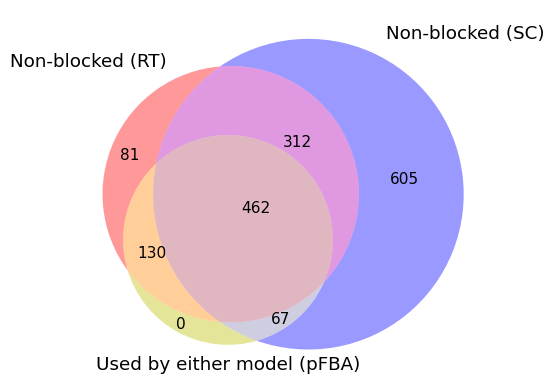

In [ ]:
# make Venn diagram of unblocked rxns
import matplotlib_venn as venn
# find reactions in each model
# rxns_sets = [common_rxns, list(rxns[0]), list(rxns[1]), unblocked_rxns_in_all_models, list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns'])]
# find rxns used in pFBA in each model
# rxns_sets = [list(i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0), list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns'])]
# set_colors=('#1b9e77','#d95f02','#7570b3')
set_colors=('r','b','y')
# sets = [list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns']), [i for i in models[1]['pfba'].fluxes.keys() if models[1]['pfba'].fluxes[i] != 0]]
# sets = [list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns']), [i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0]]
sets = [list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns']), list(set([i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0] + [i for i in models[1]['pfba'].fluxes.keys() if models[1]['pfba'].fluxes[i] != 0]))]
# rxns_sets = [common_rxns, list(rxns[0]), list(rxns[1])]
# venn_labels = ['pFBA (both)', 'pFBA (RT)', 'pFBA (SC)', 'Non-blocked (both)', 'Non-blocked (RT)', 'Non-blocked (SC)']
# venn_labels = ['pFBA (RT)', 'Non-blocked (RT)', 'Non-blocked (SC)']
# venn_labels = ['Non-blocked (RT)', 'Non-blocked (SC)', 'pFBA (SC)']
# venn_labels = ['Non-blocked (RT)', 'Non-blocked (SC)', 'pFBA (RT)']
venn_labels = ['Non-blocked (RT)', 'Non-blocked (SC)', 'Used by either model (pFBA)']
# venn_labels = ['pFBA (both)', 'pFBA (RT)', 'pFBA (SC)']
# convert elements in rxns_sets to sets
sets = [set(rxns) for rxns in sets]

# # create a Venn diagram
# venn.venn3(subsets=[list(rxns) for rxns in rxns_sets], set_labels=venn_labels)
# convert elements in rxns_sets to tuples
# rxns_sets = [tuple(rxns) for rxns in rxns_sets]
# create a Venn diagram; rotate it so non-blocked sets are on top
# don't show sections with no overlap
venn.venn3(subsets=sets, set_labels=venn_labels,set_colors=set_colors)
# save as SVG
plt.savefig('venn_diagram.svg', format='svg')

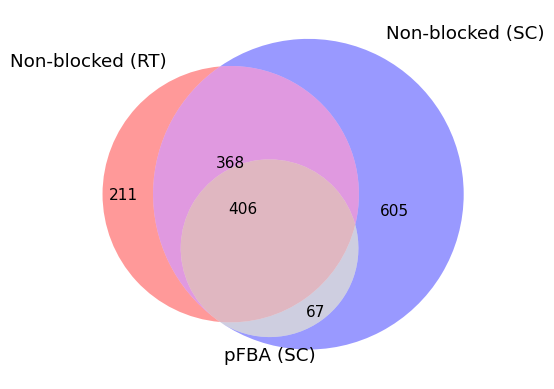

In [ ]:
# make Venn diagram of unblocked rxns
import matplotlib_venn as venn
# find reactions in each model
# rxns_sets = [common_rxns, list(rxns[0]), list(rxns[1]), unblocked_rxns_in_all_models, list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns'])]
# find rxns used in pFBA in each model
# rxns_sets = [list(i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0), list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns'])]
# set_colors=('#1b9e77','#d95f02','#7570b3')
set_colors=('r','b','y')
sets = [list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns']), [i for i in models[1]['pfba'].fluxes.keys() if models[1]['pfba'].fluxes[i] != 0]]
# sets = [list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns']), [i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0]]
# sets = [list(models[0]['unblocked-rxns']), list(models[1]['unblocked-rxns']), list(set([i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0] + [i for i in models[1]['pfba'].fluxes.keys() if models[1]['pfba'].fluxes[i] != 0]))]
# rxns_sets = [common_rxns, list(rxns[0]), list(rxns[1])]
# venn_labels = ['pFBA (both)', 'pFBA (RT)', 'pFBA (SC)', 'Non-blocked (both)', 'Non-blocked (RT)', 'Non-blocked (SC)']
# venn_labels = ['pFBA (RT)', 'Non-blocked (RT)', 'Non-blocked (SC)']
venn_labels = ['Non-blocked (RT)', 'Non-blocked (SC)', 'pFBA (SC)']
# venn_labels = ['Non-blocked (RT)', 'Non-blocked (SC)', 'pFBA (RT)']
# venn_labels = ['Non-blocked (RT)', 'Non-blocked (SC)', 'Used by either model (pFBA)']
# venn_labels = ['pFBA (both)', 'pFBA (RT)', 'pFBA (SC)']
# convert elements in rxns_sets to sets
sets = [set(rxns) for rxns in sets]

# # create a Venn diagram
# venn.venn3(subsets=[list(rxns) for rxns in rxns_sets], set_labels=venn_labels)
# convert elements in rxns_sets to tuples
# rxns_sets = [tuple(rxns) for rxns in rxns_sets]
# create a Venn diagram; rotate it so non-blocked sets are on top
# don't show sections with no overlap
venn.venn3(subsets=sets, set_labels=venn_labels,set_colors=set_colors)
# save as SVG
plt.savefig('venn_diagram.svg', format='svg')

<Axes: >

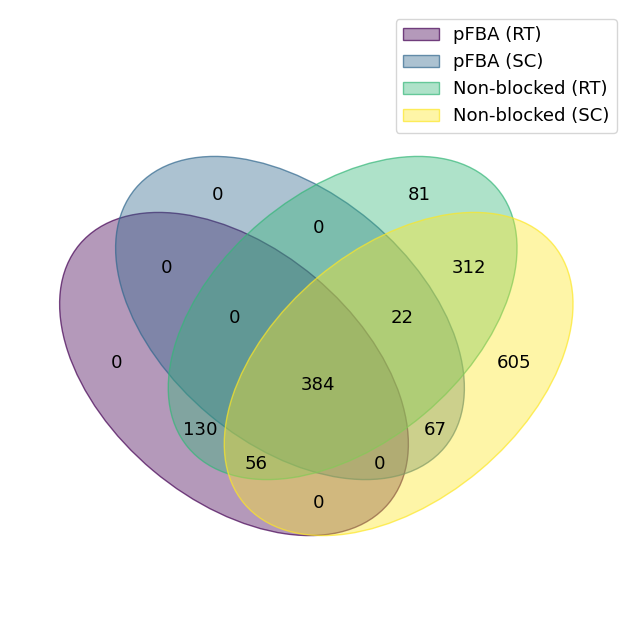

In [ ]:
# make Venn diagram of rxns used in pFBA
from venn import venn

venn_dict = {'pFBA (RT)':set(i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0), 
             'pFBA (SC)':set(i for i in models[1]['pfba'].fluxes.keys() if models[1]['pfba'].fluxes[i] != 0),
             'Non-blocked (RT)':set(models[0]['unblocked-rxns']), 
             'Non-blocked (SC)':set(models[1]['unblocked-rxns'])
             }
# create a Venn diagram
venn(venn_dict)
# import matplotlib_venn as venn
# rxns_sets = [list(i for i in models[0]['pfba'].fluxes.keys() if models[0]['pfba'].fluxes[i] != 0), list(i for i in models[1]['pfba'].fluxes.keys() if models[1]['pfba'].fluxes[i] != 0)]
# venn_labels = ['pFBA (RT)', 'pFBA (SC)']
# # convert elements in rxns_sets to sets
# rxns_sets = [set(rxns) for rxns in rxns_sets]

# # create a Venn diagram
# venn.venn2(subsets=rxns_sets, set_labels=venn_labels,set_colors=set_colors)

In [ ]:
import escher
from escher import Builder
# import cobra
# from time import sleep
#     # map_name=model.id,
#     # model=model
# import json
import igraph
from generate_escher_map import gen_map
# exclude common cofactors: ATP, NADPH, NADP, NADH, NAD, ferredoxin
gen_map(model=models[0]['model'],reactions_of_interest=models[0]['model'].reactions,common_intermediates=['atp_c'])
# builder = Builder(
#     map_json=json.load(model_path),
#     model=model
# )
# builder

Of 2308 reactions 1876 have a link
The following are only connected to other reactions by common intermediates
Generic pseudoreaction converting na1 into CATION1 (_c) [GENERIC_na1CATION1_c]::  na1_c --> CATION1_c
Generic pseudoreaction converting k into CATION1 (_m) [GENERIC_kCATION1_m]::  k_m --> CATION1_m
Generic pseudoreaction converting k into CATION1 (_e) [GENERIC_kCATION1_e]::  k_e --> CATION1_e
Generic pseudoreaction converting ca2 into metal2 (_e) [GENERIC_ca2metal2_e]::  ca2_e --> metal2_e
Generic pseudoreaction converting cobalt2 into metal2 (_e) [GENERIC_cobalt2metal2_e]::  cobalt2_e --> metal2_e
Generic pseudoreaction converting cu2 into metal2 (_e) [GENERIC_cu2metal2_e]::  cu2_e --> metal2_e
Generic pseudoreaction converting mg2 into metal2 (_e) [GENERIC_mg2metal2_e]::  mg2_e --> metal2_e
Generic pseudoreaction converting mn2 into metal2 (_e) [GENERIC_mn2metal2_e]::  mn2_e --> metal2_e
Generic pseudoreaction converting ni2 into metal2 (_e) [GENERIC_ni2metal2_e]::  ni2_e --

ValueError: Couldn't find position for side met

: 

: 